# Show Monte Carlo results for iterative and non iterative estimators

In [1]:
import numpy as np
from simulation.generate_path import generate_path
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from estimation.distance_sensor import distance_sensors
from estimation.iterative_estimator import iterative_estimator
from estimation.kalman_filter_from_points_with_acc import kalman_filter_from_points_acc
from estimation.improved_kalman_filter_from_points_with_acc import improved_kalman_filter_from_points_acc
from estimation.KF_with_mahalanobis_threshold import kalman_filter_with_mahalanobis

# For making the plots interactive, uncomment next line:
# %matplotlib widget


/home/user/miniconda3/envs/cuda_test/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# create the path

target_initial_pos = np.array([0, 0, 5000])
target_speed_xy = 50
target_speed_z = 10
target_rot_speed = 3
time_res = 0.5
sensor_sigma = 15
outlier_sensor_sigma = 200

path1 = generate_path(0, target_speed_xy, target_speed_z, target_initial_pos, time_res)
path1.add_straight_interval(100)
path1.add_xy_turn_interval(90, -np.deg2rad(target_rot_speed))
path1.add_straight_interval(100)

In [3]:
MC_iterations = 50
outlier_percentage = 2
outlier_sigma=500
sigma_a = 1
sigma_v = 100
sensor_location = [[-5000,0,0],[ 400, -7400, 0],[800, 800, 0]]

total_err_it_est = np.zeros(path1.path.shape[0])
total_err_kf_acc = np.zeros(path1.path.shape[0])
total_err_NN_kf_acc = np.zeros(path1.path.shape[0])
total_err_kf_mahal = np.zeros(path1.path.shape[0])
sensors = distance_sensors(sensor_location, sensor_sigma, outlier_percentage=outlier_percentage, outlier_sigma=outlier_sigma)

for i in range(MC_iterations):
    try:
        # Randomize noise
        sensors.calculate_measurements(path1.path)
        # sensors_noisy.calculate_measurements(path1.path)
        # estimate the path with each estimator
        it_est = iterative_estimator(sensors, path1.path[0,:])
        it_estimated_path = it_est.estimate_path(precision_limit=1)
                
        improved_KF = improved_kalman_filter_from_points_acc(time_res, sigma_a, sigma_v, non_diag_reduction_ratio=2, initial_P_multiplier=10000)
        kf_acc = kalman_filter_from_points_acc(time_res, sigma_a, sigma_v, non_diag_reduction_ratio=2, initial_P_multiplier=10000)
        kf_mahal = kalman_filter_with_mahalanobis(time_res, sigma_a, sigma_v, non_diag_reduction_ratio=2, mahalanobis_threshold=3, initial_P_multiplier=10000)
                
        kf_path_acc = kf_acc.filter_path(it_estimated_path)
        kf_path_NN = improved_KF.filter_path(it_estimated_path)
        kf_path_mahal = kf_mahal.filter_path(it_estimated_path)

        # calculate current error
        estimation_error_iter = np.sqrt(np.sum(np.square(it_estimated_path-path1.path), 1))
        estimation_error_kf_acc = np.sqrt(np.sum(np.square(kf_path_acc-path1.path), 1))
        estimation_error_NN_kf_acc = np.sqrt(np.sum(np.square(kf_path_NN-path1.path), 1))
        estimation_error_kf_mahal = np.sqrt(np.sum(np.square(kf_path_mahal-path1.path), 1))
        # update average error
        total_err_it_est += estimation_error_iter
        total_err_kf_acc += estimation_error_kf_acc
        total_err_NN_kf_acc += estimation_error_NN_kf_acc
        total_err_kf_mahal += estimation_error_kf_mahal
    except KeyboardInterrupt:
        print(f"stopped after {i} iterations")
        i = i-1
        break

mean_err_it_est = total_err_it_est / (i+1)
mean_err_kf_acc = total_err_kf_acc / (i+1)
mean_err_NN_kf_acc = total_err_NN_kf_acc / (i+1)
mean_err_kf_mahal = total_err_kf_mahal / (i+1)




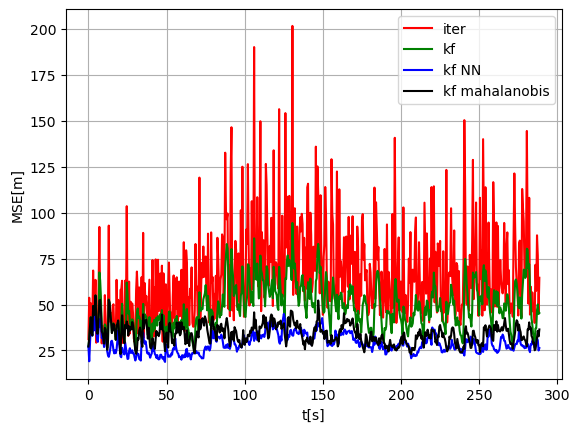

In [4]:
t = path1.time

plt.figure()
# plt.plot(t, sensors.outlier_distances*10000, color='y')
plt.plot(t, mean_err_it_est, label=f'iter', color='r')
plt.plot(t, mean_err_kf_acc, label=f'kf', color='g')
plt.plot(t, mean_err_NN_kf_acc, label=f'kf NN', color='b')
plt.plot(t, mean_err_kf_mahal, label=f'kf mahalanobis', color='k')
plt.xlabel('t[s]')
plt.ylabel('MSE[m]')
plt.grid()
plt.legend()
plt.show()
